# **Analysis and prediction of rental house prices in Bucharest, September 2020** 




## Import libraries

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from numpy import mean
from numpy import std
from datetime import datetime

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

## Utility Functions

In [ ]:
# function to print a timestamp before a message
def printt(msg, end='\n'):
    now = datetime.now()
    time = now.strftime("[%H:%M:%S]")
    print(time, msg, end=end)

##**Cleaning the data** 

The data will be modified as follows:
*   construction_year: missig values will be replaced by the mean per location
*   price - remove the outliers 
*   max_level – we can use the mode if it s bigger than level, else we use level
*   location_area - will be changed to numerical data
*   seller_type, type -drop this columns
*   partitioning, confort, real_estate_type – will be changed to numerical data
*   useful/build surface - are complementary (completing the missing values); if they ar both missing, use the average useful/buid surface
*   build_surface - will be deleted
*   level - all numerical data (no "parter" or "ultimele 2 etaje")
*   kitchens and bathrooms - might be related to useful/build surface
*   garages, parking_lots, balconies - 0 where null

In [ ]:
#read the data from the csv file
def read_csv_file(csvPath, data=[]):
  with open(csvPath, 'r') as csvFile:
    csvReader=csv.reader(csvFile)
    for row in csvReader:
      data.append(row)

rentalOffers=[]
read_csv_file('house_rentals.csv', rentalOffers)
#print((np.array(rentalOffers)).shape)
#print(rentalOffers[0])
rentalOffers=np.array(rentalOffers)
print(rentalOffers.shape)

#get the position of the column in data or a message, in case there is no such column
def get_index_column(data, columnName):
  column=np.array(np.where(rentalOffers[0] ==columnName))
  if column.shape[1]==1:
    return column[0][0]
  else:
    return 'No column'

### price - get rid of the outliers

#check wether the price column was removed or not
price=np.array(np.where(rentalOffers[0] =='price'))
if price.shape[1]==1:
  price=price[0][0]
print(price)
'''
#find min and max  price
prices=np.array(list(map(int,rentalOffers[1:,price])))
bincount=np.bincount(prices)
print('Number of offers and price')
for i in range(0, len(bincount)):
  if bincount[i]>0:
    print(bincount[i],i)
'''
minPrice=70
maxPrice=9000

i=1
while i<rentalOffers.shape[0]:
  if rentalOffers[i,price].isnumeric():
    if int(rentalOffers[i][price])<=minPrice:
      print(int(rentalOffers[i][price]),'<=',minPrice)
      rentalOffers=np.delete(rentalOffers, i, axis=0)
    elif int(rentalOffers[i][price])>=maxPrice:
      print(int(rentalOffers[i][price]),'>=',maxPrice)
      rentalOffers=np.delete(rentalOffers, i, axis=0)
  i+=1
print(rentalOffers.shape)

### garages, parking_lots, balconies - 0 where null
# the last 3 positions must be completed by 0
garages=np.array(np.where(rentalOffers[0] == 'garages_count'))
parking_lots=np.array(np.where(rentalOffers[0] == 'parking_lots_count'))
balconies_count=np.array(np.where(rentalOffers[0] == 'balconies_count'))
gpb=[]
if garages.shape[1]==1:
  gpb.append(garages[0][0])
if parking_lots.shape[1]==1:
  gpb.append(parking_lots[0][0])
if balconies_count.shape[1]==1:
  gpb.append(balconies_count[0][0])
print(gpb)

for offer in rentalOffers[1:]:
  for idx in gpb:
    if offer[idx].isnumeric():
      offer[idx]=int(offer[idx])
    else:
      offer[idx]=0


### max_level – we can use the mode if it s bigger than level, else we use level
### level - all numerical data (no "parter" or "ultimele 2 etaje")

# we will consider "parter"=0, "subsol"=-1 and "mansarda"= the last floor+1 
#we need : max_level, level, height_regime
maxLevel=get_index_column(rentalOffers, 'max_level')
level=get_index_column(rentalOffers, 'level')
heightRegime=get_index_column(rentalOffers, 'height_regime')
locationArea=get_index_column(rentalOffers,'location_area')

if type(maxLevel)==str:
  print("maxLevel is not a column of your data")
if type(level)==str:
  print("level is not a column of your data")
if type(heightRegime)==str:
  print("heightRegime is not a column of your data")
if type(locationArea)==str:
  print("locationArea is not a column of your data")

### level - all numerical data (no "parter" or "ultimele 2 etaje")
# "Demisol"=-1, "Parter"=0 ,"Mansarda"=last floor+1, "Ultimele 2 etaje"=last floor-1
for i in range(1, rentalOffers.shape[0]):
  if rentalOffers[i][level].isnumeric()==False:
    #print(rentalOffers[i][level])
    if rentalOffers[i][level]=='Parter':
      rentalOffers[i][level]=0
    if rentalOffers[i][level]=='Demisol':
      rentalOffers[i][level]=-1
    if rentalOffers[i][level]=='Mansarda':
      if rentalOffers[i][maxLevel].isnumeric():
        rentalOffers[i][level]=int(rentalOffers[i][maxLevel])+1
      else:
        print(rentalOffers[i][heightRegime])
    if rentalOffers[i][level]=='Ultimele 2 etaje':
      if rentalOffers[i][maxLevel].isnumeric():
        #print(rentalOffers[i][level], rentalOffers[i][maxLevel])
        rentalOffers[i][level]=int(rentalOffers[i][maxLevel])-1
        #print(rentalOffers[i][level])
      else:
        print(rentalOffers[i][heightRegime])


### max_level – we can use the mode if it s bigger than level, else we use level

areaMaxLevel=dict()

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][locationArea] in areaMaxLevel:
    if rentalOffers[i][maxLevel].isnumeric():
      (maxL, count)=areaMaxLevel[rentalOffers[i][locationArea]]
      maxL+=int(rentalOffers[i][maxLevel])
      count+=1
      areaMaxLevel[rentalOffers[i][locationArea]]=(maxL, count)
  else:
    if rentalOffers[i][maxLevel].isnumeric():
      maxL=int(rentalOffers[i][maxLevel])
      count=1
    else:
      maxL=0
      count=0
    areaMaxLevel[rentalOffers[i][locationArea]]=(maxL, count)

averageLevel=dict()
for area in areaMaxLevel:
  (maxL, count)=areaMaxLevel[area]
  if count!=0:
    averageL=int(maxL/count)
  else:
    averageL=0
  averageLevel[area]=averageL


for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][maxLevel].isnumeric()!=True:
    averageL=averageLevel[rentalOffers[i][locationArea]]
    if averageL==0 and rentalOffers[i][level].isnumeric()==True:
      averageL=int(rentalOffers[i][level])
    rentalOffers[i][maxLevel]=averageL




### location_area - numerical data

locationArea=get_index_column(rentalOffers, 'location_area')
if type(locationArea)==str:
  print("locationArea is not a column of your data")


numericalData=dict()
count=0

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][locationArea] in numericalData:
    count+=0
  else:
    numericalData[rentalOffers[i][locationArea]]=count
    count+=1

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][locationArea] in numericalData:
    rentalOffers[i][locationArea]=numericalData[rentalOffers[i][locationArea]]




### construction_year – mean per zone 
constructionYear=get_index_column(rentalOffers, 'construction_year')
if type(constructionYear)==str:
  print("constructionYear is not a column of your data")

averageConstructionYear=dict() # key= location_area, value=(sum_years, count_offers)
averageYearsOverall=(0,0) # value=(sum_years, count_offers)
for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][locationArea] in averageConstructionYear:
    if rentalOffers[i][constructionYear].isnumeric():
      (year, count)=averageConstructionYear[rentalOffers[i][locationArea]]
      year+=int(rentalOffers[i][constructionYear])
      count+=1
      averageConstructionYear[rentalOffers[i][locationArea]]=(year, count)
  else:
    if rentalOffers[i][constructionYear].isnumeric():
      year=int(rentalOffers[i][constructionYear])
      count=1
    else:
      year=0
      count=0
    averageConstructionYear[rentalOffers[i][locationArea]]=(year, count)

yearAverage=dict() # key= location_area, value= sum_years/count
for area in averageConstructionYear:
  (year, count)=averageConstructionYear[area]
  if count!=0:
    averageY=int(year/count)
  else:
    averageY=0
  yearAverage[area]=averageY

#there are areas where there is no value set for the year so we will replace it with the mean year overall
meanYear=0
areas=0
for area in yearAverage:
  (year,count)=averageConstructionYear[area]
  if year!=0:
    meanYear+=year
    areas+=count
meanYear=int(meanYear/areas)
print("meanYear:   ",meanYear)

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][constructionYear].isnumeric()!=True:
    averageY=yearAverage[rentalOffers[i][locationArea]]
    if averageY==0:
      averageY=meanYear
    rentalOffers[i][constructionYear]=averageY


### useful/build surface - are maybe complementary (completing the missing values)
usefulSurface=get_index_column(rentalOffers, 'useful_surface')
if type(usefulSurface)==str:
  print("useful_surface is not a column of your data")

builtSurface=get_index_column(rentalOffers, 'built_surface')
if type(builtSurface)==str:
  print("built_surface is not a column of your data")
print(usefulSurface,builtSurface)


count=0
final=0

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][usefulSurface]!='' and rentalOffers[i][builtSurface]=='':
    rentalOffers[i][builtSurface]=rentalOffers[i][usefulSurface]
  if rentalOffers[i][usefulSurface]=='' and rentalOffers[i][builtSurface]!='':
    rentalOffers[i][usefulSurface]=rentalOffers[i][builtSurface]
  if rentalOffers[i][usefulSurface]!='' and rentalOffers[i][builtSurface]!='':
    count+=1
  else:
    final+=1




### partitioning, confort, real_estate_type – numerical data
#partitioning
partitioning=get_index_column(rentalOffers, 'partitioning')
if type(partitioning)==str:
  print("partitioning is not a column of your data")

dictionaryPartitioning=dict() # key=type, value=number

count=1
for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][partitioning] in dictionaryPartitioning:
    rentalOffers[i][partitioning]=dictionaryPartitioning[rentalOffers[i][partitioning]]
  elif rentalOffers[i][partitioning]!='':
    dictionaryPartitioning[rentalOffers[i][partitioning]]=count
    rentalOffers[i][partitioning]=count
    count+=1
  elif rentalOffers[i][partitioning]=='':
    # Set the missing values for partitiong with the 'decomandat' value (which is encoded as 1), since it is the mode in our dataset (68%)
    dictionaryPartitioning['']=1
    rentalOffers[i][partitioning]=1

### comfort, real_estate_type – numerical data
comfort=get_index_column(rentalOffers, 'comfort')
if type(comfort)==str:
  print("comfort is not a column of your data")

for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][comfort]=='lux':
    rentalOffers[i][comfort]='4'
  elif rentalOffers[i][comfort]=='1':
    rentalOffers[i][comfort]='3'
  elif rentalOffers[i][comfort]=='2':
    rentalOffers[i][comfort]='2'
  elif rentalOffers[i][comfort]=='3':
    rentalOffers[i][comfort]='1'
  elif rentalOffers[i][comfort]=='':
    rentalOffers[i][comfort]='3'


### real_estate_type – numerical data
realEstateType=get_index_column(rentalOffers, 'real_estate_type')
if type(realEstateType)==str:
  print("realEstateType is not a column of your data")
"""
dictionaryRealEstateType={"bloc de apartamente":1, "casa/vila":0, '':1}
for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][realEstateType] in dictionaryRealEstateType:
    rentalOffers[i][realEstateType]=dictionaryRealEstateType[rentalOffers[i][realEstateType]]
  else:
    rentalOffers[i][realEstateType]=0

"""
dictionaryRealEstateType=dict() # key=type, value=number

count=0
for i in range(1,rentalOffers.shape[0]):
  if rentalOffers[i][realEstateType] in dictionaryRealEstateType:
    rentalOffers[i][realEstateType]=dictionaryRealEstateType[rentalOffers[i][realEstateType]]
  elif rentalOffers[i][realEstateType]!='':
    dictionaryRealEstateType[rentalOffers[i][realEstateType]]=count
    rentalOffers[i][realEstateType]=count
    count+=1
  elif rentalOffers[i][realEstateType]=='':
    # Set the missing values for real_estate_type with the 'bloc de apartamente' value (which is encoded as 0), 
    # since it is the mode in our dataset (97%)
    dictionaryRealEstateType['']=0
    rentalOffers[i][realEstateType]=0


### kitchens and bathrooms - might be related to useful/build surface
buildSurface=get_index_column(rentalOffers, 'built_surface')
usefulSurface=get_index_column(rentalOffers, 'useful_surface')
kitchens=get_index_column(rentalOffers, 'kitchens_count')
bathrooms=get_index_column(rentalOffers, 'bathrooms_count')
for i in range(1, rentalOffers.shape[0]):
  if   rentalOffers[i][usefulSurface].isnumeric()==False or int(rentalOffers[i][usefulSurface]) < 50:
    if rentalOffers[i][kitchens].isnumeric()==False or int(rentalOffers[i][kitchens]) > 3 :
      rentalOffers[i][kitchens]=1
    if  rentalOffers[i][bathrooms].isnumeric()==False or int(rentalOffers[i][bathrooms]) > 3 :
      rentalOffers[i][bathrooms]=1
  else:
    if rentalOffers[i][kitchens].isnumeric()==False:
      rentalOffers[i][kitchens]=1
    if rentalOffers[i][bathrooms].isnumeric()==False:
      rentalOffers[i][bathrooms]=1

### seller_type, type -drop this columns
# seller_type -> position 3

sellerType=np.array(np.where(rentalOffers[0] == 'seller_type'))
if sellerType.shape[1]==1:
  sellerType=sellerType[0][0]
  rentalOffers=np.delete(rentalOffers,sellerType,axis=1)

(9807, 21)
7
11000 >= 9000
70 <= 70
24 <= 70
89000 >= 9000
139000 >= 9000
39900 >= 9000
9500 >= 9000
(9800, 21)
[18, 19, 20]
meanYear:    1995
9 10


In [ ]:
#### Write Proccessed Data to a new CSV

with open('house_rentals_clean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for line in rentalOffers:
      writer.writerow(line)

rental = pd.read_csv('house_rentals_clean.csv')
X = rental.drop(['id','location','type','price','height_regime', 'built_surface','bathrooms_count','rooms_count'],axis=1)

X['useful_surface'].isnull().sum()
X['useful_surface'].mean()
X['useful_surface'] = X['useful_surface'].replace(np.NaN,int(X['useful_surface'].mean()))
X['useful_surface'].isnull().sum()

X.to_csv('house_rentals_features_1.csv', index=False)

## Plot how the features are correlated to each other, and to price

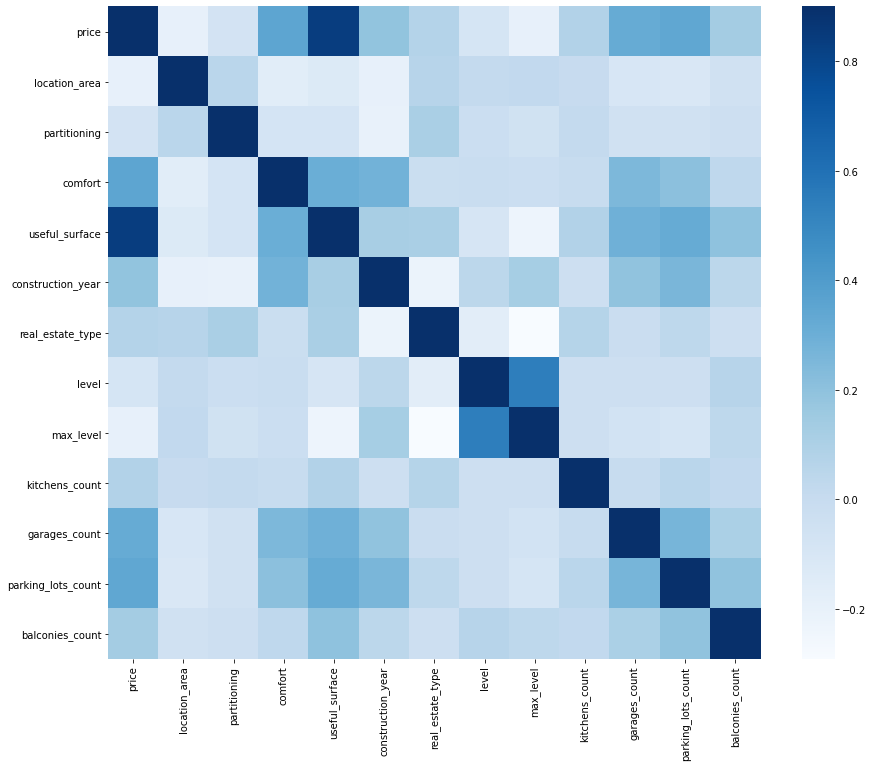

In [ ]:
corr = X.corr()

X_with_price = pd.concat([rental['price'], X], axis=1)
corr = X_with_price.corr()

plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

## **One hot encoding for categorical data**

In [ ]:
def OneHotEncoding(df, columns):
    print('Before One Hot Encoding:',df.shape)
    lenght = df.shape[0]    
    df = pd.get_dummies(data = df, columns= columns)    
    print('After One Hot Encoding:',df.shape)
    return df

categorical_col = []
categorical_col.append('location_area')
categorical_col.append('partitioning')
categorical_col.append('real_estate_type')
X = OneHotEncoding(X, columns=categorical_col)

X.to_csv('house_rentals_features_2.csv', index=False)

Before One Hot Encoding: (9799, 12)
After One Hot Encoding: (9799, 196)


In [ ]:
#### Normalize the data relative to the max value

target_column = ['price'] 
X=X/X.max()
X.head()

,comfort,useful_surface,construction_year,level,max_level,kitchens_count,garages_count,parking_lots_count,balconies_count,location_area_0,location_area_1,location_area_2,location_area_3,location_area_4,location_area_5,location_area_6,location_area_7,location_area_8,location_area_9,location_area_10,location_area_11,location_area_12,location_area_13,location_area_14,location_area_15,location_area_16,location_area_17,location_area_18,location_area_19,location_area_20,location_area_21,location_area_22,location_area_23,location_area_24,location_area_25,location_area_26,location_area_27,location_area_28,location_area_29,location_area_30,...,location_area_147,location_area_148,location_area_149,location_area_150,location_area_151,location_area_152,location_area_153,location_area_154,location_area_155,location_area_156,location_area_157,location_area_158,location_area_159,location_area_160,location_area_161,location_area_162,location_area_163,location_area_164,location_area_165,location_area_166,location_area_167,location_area_168,location_area_169,location_area_170,location_area_171,location_area_172,location_area_173,location_area_174,location_area_175,location_area_176,location_area_177,location_area_178,location_area_179,partitioning_1,partitioning_2,partitioning_3,partitioning_4,partitioning_5,real_estate_type_0,real_estate_type_1
0,1.00,0.176,0.998020,0.20,0.250000,0.5,0.333333,0.066667,0.045455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.00,0.126,0.998020,0.60,0.250000,0.5,0.333333,0.066667,0.045455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.00,0.180,0.999505,0.15,0.153846,0.5,0.333333,0.066667,0.045455,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.75,0.126,1.000000,0.30,0.211538,0.5,0.000000,0.066667,0.045455,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.00,0.108,0.998515,0.15,0.250000,0.5,0.000000,0.066667,0.045455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Reducing the Dimensionality

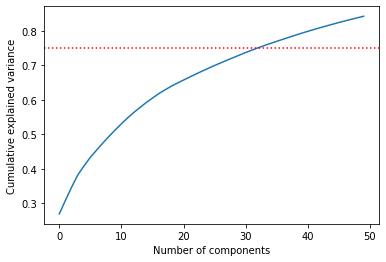

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_[0:50]))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.axhline(y = 0.75, color = 'r', linestyle = ':')

In [ ]:
def transform_using_PCA(X):
    pca = PCA(n_components = 32)
    pca_32 = pca.fit_transform(X)
    return pca_32
def transform_using_kernel_PCA(X):
    kernel_PCA = KernelPCA(n_components=32)
    kernel_PCA_32 = kernel_PCA.fit_transform(X)
    return kernel_PCA_32

def transform_using_tSNE(X):
    tsne = TSNE(n_components=3)
    tsne_3 = tsne.fit_transform(transform_using_PCA(X))
    return tsne_3

X_PCA = transform_using_PCA(X)

X_kernel_PCA = transform_using_kernel_PCA(X)

X_tSNE = transform_using_tSNE(X)

In [ ]:
pd.DataFrame(X_PCA).to_csv('house_rentals_features_2_PCA.csv', index=False)
pd.DataFrame(X_kernel_PCA).to_csv('house_rentals_features_2_kernel_PCA.csv', index=False)
pd.DataFrame(X_tSNE).to_csv('house_rentals_features_2_tSNE.csv', index=False)

In [ ]:
X_PCA = pd.read_csv('house_rentals_features_2_PCA.csv')
X_kernel_PCA = pd.read_csv('house_rentals_features_2_kernel_PCA.csv')
X_tSNE = pd.read_csv('house_rentals_features_2_tSNE.csv')
X_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,-0.434458,-0.688597,0.551350,0.422435,-0.018511,0.048041,0.026969,0.006142,0.012533,0.022247,-0.005968,-0.010189,0.027396,-0.008837,0.001442,0.023820,0.057366,0.027877,0.076626,0.002567,-0.006854,-0.018102,0.018011,-0.010426,0.025749,-0.016131,0.006848,0.014508,0.030383,0.015862,-0.004876,-0.006266
1,-0.435221,-0.721344,0.496307,0.407307,-0.015101,0.019095,0.083200,0.041591,0.050616,-0.006662,-0.101050,-0.060258,0.054991,-0.046529,0.029350,0.221148,0.280805,-0.073909,0.192371,-0.053080,-0.024891,-0.024683,0.046276,-0.013748,0.018338,0.042711,0.013162,0.016133,0.036094,0.033193,0.027776,-0.008200
2,-0.424171,-0.044754,0.010800,-0.083826,0.058065,-0.171849,-0.556962,-0.245567,0.692200,0.345332,0.023678,0.001558,0.098976,-0.005093,-0.013900,-0.044385,0.067739,0.067439,0.066307,0.017116,-0.000938,-0.027468,0.016633,-0.004736,0.032908,-0.019967,0.010645,0.019828,0.037601,0.017455,-0.014252,0.000621
3,-0.430203,-0.029906,-0.098329,-0.201316,0.704678,0.594803,0.108538,0.024877,0.032058,0.047526,-0.033944,-0.021232,0.033657,-0.018402,0.010313,0.033124,0.126627,-0.080929,-0.049226,-0.017149,-0.005282,-0.005214,-0.005922,-0.010011,-0.009257,0.039242,-0.012258,-0.016167,-0.033740,-0.018536,0.002161,-0.013857
4,-0.430475,-0.662631,0.531401,0.409312,-0.036569,0.051483,0.057233,0.018267,0.010712,0.016246,-0.020245,-0.014904,0.006506,-0.006015,0.000826,-0.006749,0.044233,-0.020685,-0.053902,0.003677,0.002831,-0.020563,-0.010720,0.007870,-0.006596,-0.019684,0.014013,0.005467,-0.006026,0.004354,0.009013,-0.009580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9794,0.980762,0.282211,-0.459675,0.800865,0.001800,0.087487,0.000975,-0.021151,0.003833,0.019791,0.023729,0.012859,0.031087,-0.005309,-0.016198,-0.057272,-0.047618,0.017189,-0.073047,0.013101,-0.007017,-0.017793,-0.028372,0.005655,-0.016156,-0.001265,-0.013383,-0.009314,-0.017199,-0.005866,-0.013536,-0.003141
9795,-0.435714,-0.703771,0.537974,0.422150,-0.013850,0.034486,0.042755,0.020064,0.027129,0.011350,-0.042776,-0.027588,0.041772,-0.022705,0.013575,0.114772,0.155167,-0.011049,0.150758,-0.024459,-0.014095,-0.019939,0.034075,-0.010324,0.022846,0.020893,0.009777,0.016430,0.036492,0.024040,0.009329,-0.000129
9796,-0.399969,0.005443,-0.067425,-0.130859,-0.026359,-0.186798,0.201614,0.761676,0.032045,0.463712,0.218548,0.062396,0.091323,0.025201,-0.033991,-0.145456,-0.039743,0.078945,-0.045832,0.036862,0.013866,-0.028365,-0.015397,0.002941,0.012432,-0.027059,0.006542,0.004633,-0.004347,-0.010467,-0.019735,-0.002405
9797,-0.417080,0.048147,0.027550,-0.086285,-0.001363,-0.101962,-0.066653,0.021188,-0.051500,-0.270001,-0.092442,0.867952,0.302877,-0.010673,-0.027945,-0.074196,0.112359,-0.003557,-0.054309,0.006816,0.007244,-0.007024,-0.006433,-0.002006,0.004288,0.023222,-0.006576,-0.008065,-0.021155,-0.017180,-0.010674,-0.002471


## **Separate train/test data**

In [ ]:
y = rental[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.30, random_state=40)
X_kernel_PCA_train, X_kernel_PCA_test, y_kernel_PCA_train, y_kernel_PCA_test = train_test_split(X_kernel_PCA, y, test_size=0.30, random_state=40)
X_tSNE_train, X_tSNE_test, y_tSNE_train, y_tSNE_test = train_test_split(X_tSNE, y, test_size=0.30, random_state=40)


scaler = preprocessing.Normalizer()
scaler.fit(X_train)
train_data = scaler.transform(X_train)     # Use this in training the model
test_data = scaler.transform(X_test)

scaler = preprocessing.Normalizer()
scaler.fit(X_PCA_train)
PCA_train_data = scaler.transform(X_PCA_train)   # Use this in training the model with PCA dimension reduction
PCA_test_data = scaler.transform(X_PCA_test)

scaler = preprocessing.Normalizer()
scaler.fit(X_kernel_PCA_train)
kernel_PCA_train_data = scaler.transform(X_kernel_PCA_train)   # Use this in training the model with Kernel PCA dimension reduction
kernel_PCA_test_data = scaler.transform(X_kernel_PCA_test)

scaler = preprocessing.Normalizer()
scaler.fit(X_tSNE_train)
tSNE_train_data = scaler.transform(X_tSNE_train)   # Use this in training the model with t-SNE dimension reduction
tSNE_test_data = scaler.transform(X_tSNE_test)

## **Gradient Boosting Regressor** - w/o dim reduction

In [ ]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=857,
                                learning_rate=0.01,
                                max_depth=4,
                                min_samples_leaf=8,
                                min_samples_split=33,
                                loss='huber',)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

pred_train_gbr= gbr.predict(X_train)
print('Mean squared error for train: '+ str(mean_squared_error(y_train,pred_train_gbr)))
print('Mean absolute error for train: '+ str(mean_absolute_error(y_train,pred_train_gbr)))
print('R2 for train: '+ str(r2_score(y_train, pred_train_gbr)))

pred_test_gbr= gbr.predict(X_test)
print('Mean squared error for test: '+ str(mean_squared_error(y_test,pred_test_gbr)))
print('Mean absolute error for test: '+ str(mean_absolute_error(y_test,pred_test_gbr)))
print('R2 for test: '+ str(r2_score(y_test, pred_test_gbr)))

GradientBoosting


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error for train: 51922.48687863131
Mean absolute error for train: 114.35661083033736
R2 for train: 0.8524087294607123
Mean squared error for test: 60526.416620818774
Mean absolute error for test: 122.09515177901521
R2 for test: 0.8226125232896128


In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_gbr)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_gbr
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

#### PCA


In [ ]:
gbr.fit(X_PCA_train, y_PCA_train)

pred_train_PCAgbr= gbr.predict(X_PCA_train)
print('Mean squared error for PCA dim reduced train: '+ str(mean_squared_error(y_PCA_train,pred_train_PCAgbr)))
print('Mean absolute error for PCA dim reduced train: '+ str(mean_absolute_error(y_PCA_train,pred_train_PCAgbr)))
print('R2 for PCA dim reduced train: '+ str(r2_score(y_PCA_train, pred_train_PCAgbr)))

pred_test_PCAgbr= gbr.predict(X_PCA_test)
print('Mean squared error for PCA dim reduced test: '+ str(mean_squared_error(y_PCA_test,pred_test_PCAgbr)))
print('Mean absolute error PCA dim reduced for test: '+ str(mean_absolute_error(y_PCA_test,pred_test_PCAgbr)))
print('R2 for PCA dim reduced test: '+ str(r2_score(y_PCA_test, pred_test_PCAgbr)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error for PCA dim reduced train: 64707.82852146462
Mean absolute error for PCA dim reduced train: 120.47447979461343
R2 for PCA dim reduced train: 0.8160660014678198
Mean squared error for PCA dim reduced test: 90906.92878706657
Mean absolute error PCA dim reduced for test: 148.5830481740564
R2 for PCA dim reduced test: 0.7335749972767764


#### Kernel PCA

In [ ]:
gbr.fit(X_kernel_PCA_train, y_kernel_PCA_train)

pred_train_kPCAgbr= gbr.predict(X_kernel_PCA_train)
print('Mean squared error for kernel PCA dim reduced train: '+ str(mean_squared_error(y_kernel_PCA_train,pred_train_kPCAgbr)))
print('Mean absolute error for kernel PCA dim reduced train: '+ str(mean_absolute_error(y_kernel_PCA_train,pred_train_kPCAgbr)))
print('R2 for kernel PCA dim reduced train: '+ str(r2_score(y_kernel_PCA_train, pred_train_kPCAgbr)))

pred_test_kPCAgbr= gbr.predict(X_kernel_PCA_test)
print('Mean squared error for kernel PCA dim reduced test: '+ str(mean_squared_error(y_kernel_PCA_test,pred_test_kPCAgbr)))
print('Mean absolute error kernel PCA dim reduced for test: '+ str(mean_absolute_error(y_kernel_PCA_test,pred_test_kPCAgbr)))
print('R2 for kernel PCA dim reduced test: '+ str(r2_score(y_kernel_PCA_test, pred_test_kPCAgbr)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error for kernel PCA dim reduced train: 90421.04265537555
Mean absolute error for kernel PCA dim reduced train: 146.55194423572397
R2 for kernel PCA dim reduced train: 0.7429753971494327
Mean squared error for kernel PCA dim reduced test: 119178.25391995226
Mean absolute error kernel PCA dim reduced for test: 173.2890093056004
R2 for kernel PCA dim reduced test: 0.650718960052584


#### t-SNE

In [ ]:
gbr.fit(X_tSNE_train, y_tSNE_train)

pred_train_tsnegbr= gbr.predict(X_tSNE_train)
print('Mean squared error for t-SNE dim reduced train: '+ str(mean_squared_error(y_tSNE_train,pred_train_tsnegbr)))
print('Mean absolute error for t-SNE dim reduced train: '+ str(mean_absolute_error(y_tSNE_train,pred_train_tsnegbr)))
print('R2 for t-SNE dim reduced train: '+ str(r2_score(y_tSNE_train, pred_train_tsnegbr)))

pred_test_tsnegbr= gbr.predict(X_tSNE_test)
print('Mean squared error for t-SNE dim reduced test: '+ str(mean_squared_error(y_tSNE_test, pred_test_tsnegbr)))
print('Mean absolute error t-SNE dim reduced for test: '+ str(mean_absolute_error(y_tSNE_test, pred_test_tsnegbr)))
print('R2 for t-SNE dim reduced test: '+ str(r2_score(y_tSNE_test, pred_test_tsnegbr)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error for t-SNE dim reduced train: 213128.5649689455
Mean absolute error for t-SNE dim reduced train: 224.81033545687646
R2 for t-SNE dim reduced train: 0.3941754799705587
Mean squared error for t-SNE dim reduced test: 221148.82006669836
Mean absolute error t-SNE dim reduced for test: 234.79112665753294
R2 for t-SNE dim reduced test: 0.3518692604112007


## **Random Forests** - w/o dim reduction

In [ ]:
houses = pd.read_csv('house_rentals_clean.csv')
house_features_1 = pd.read_csv('house_rentals_features_1.csv')
house_features_2 = pd.read_csv('house_rentals_features_2.csv')

In [ ]:
y = np.ravel(houses[['price']].values)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(house_features_1, y, test_size=0.30, random_state=40)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(house_features_2, y, test_size=0.30, random_state=40)
y_train = y_train_1 = y_train_2
y_test = y_test_1 = y_test_2

print(X_train_1.shape); print(X_test_1.shape)
print(X_train_2.shape); print(X_test_2.shape)

(6859, 12)
(2940, 12)
(6859, 196)
(2940, 196)


In [ ]:
printt('Started looking for the best Random Forest...')

forest_model = RandomForestRegressor(random_state=0, n_jobs=-1)
rsCV = RandomizedSearchCV(forest_model, n_iter=10, param_distributions={
    'n_estimators': list(range(500, 1000)),
    'min_samples_split': np.linspace(0,0.01,100) * 1.0,
    'min_samples_leaf': list(range(1, 50)),
    'min_impurity_decrease': np.linspace(0,0.1,100) * 1.0,
    'n_jobs': [-1]  # use all the CPU's cores
})
# rsCV.fit(X_train_1, y_train)
rsCV.fit(X_train_2, y_train)

printt('Found best estimator: ')
print(rsCV.best_estimator_)

pred_train_forest = rsCV.predict(X_train_2)
print(f'On train MSE: {mean_squared_error(y_train,pred_train_forest)}')
print(f'On train MAE: {mean_absolute_error(y_train,pred_train_forest)}')
print(f'On train R^2: {r2_score(y_train, pred_train_forest)}')
print()

pred_test_forest = rsCV.predict(X_test_2)
print(f'On test MSE: {mean_squared_error(y_test, pred_test_forest)}') 
print(f'On test MAE: {mean_absolute_error(y_test, pred_test_forest)}')
print(f'On test R^2: {r2_score(y_test, pred_test_forest)}')

[14:24:26] Started looking for the best Random Forest...


### PCA

In [ ]:
rsCV.fit(X_PCA_train,y_train)

pred_train_rsCV_PCA= rsCV.predict(X_PCA_train)
print('MSE of training dataset after PCA dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_rsCV_PCA))
print('MAE of training dataset  after PCA dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_rsCV_PCA))
print('R2 Score of training dataset  after PCA dim reduction: %0.2f ' % r2_score(y_train, pred_train_rsCV_PCA))

pred_test_rsCV_PCA= rsCV.predict(X_PCA_test)
print('MSE of test dataset  after PCA dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_rsCV_PCA))
print('MAE of test dataset  after PCA dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_rsCV_PCA))
print('R2 Score of test dataset  after PCA dim reduction: %0.2f' % r2_score(y_test, pred_test_rsCV_PCA))

### kernel PCA

In [ ]:
rsCV.fit(X_kernel_PCA_train,y_train)

pred_train_rsCV_kPCA= rsCV.predict(X_kernel_PCA_train)
print('MSE of training dataset after kernel PCA dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_rsCV_kPCA))
print('MAE of training dataset  after kernel PCA dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_rsCV_kPCA))
print('R2 Score of training dataset  after kernel PCA dim reduction: %0.2f ' % r2_score(y_train, pred_train_rsCV_kPCA))

pred_test_rsCV_kPCA= rsCV.predict(X_kernel_PCA_test)
print('MSE of test dataset  after kernel PCA dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_rsCV_kPCA))
print('MAE of test dataset  after kernel PCA dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_rsCV_kPCA))
print('R2 Score of test dataset  after kernel PCA dim reduction: %0.2f' % r2_score(y_test, pred_test_rsCV_kPCA))

### t-SNE

In [ ]:
rsCV.fit(X_tSNE_train,y_train)

pred_train_tsne_rsCV= rsCV.predict(X_tSNE_train)
print('MSE of training dataset after tsne dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_tsne_rsCV))
print('MAE of training dataset  after tsne  dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_tsne_rsCV))
print('R2 Score of training dataset  after tsne  dim reduction: %0.2f ' % r2_score(y_train, pred_train_tsne_rsCV))

pred_test_tsne_rsCV= rsCV.predict(X_tSNE_test)
print('MSE of test dataset  after tsne  dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_tsne_rsCV))
print('MAE of test dataset  after tsne  dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_tsne_rsCV))
print('R2 Score of test dataset  after tsne  dim reduction: %0.2f' % r2_score(y_test, ppred_test_tsne_rsCV))

### Some results (random forest, no dim reduction)

MSE, MAE, and R^2 are the scores on the test subset. The RandomizedSearchCV will use the R^2 (the estimators' score method) to find the best random forest

#### Using simple features

| n_estimators | min_samples_leaf | min_samples_split | min_impurity_decrease | MSE | MAE | R^2 |
|---|---|---|---|---|---|---|
| 857 | 8 | 0.0048484848484848485 | 0.012121212121212121 | 67379.7263235 | 128.77371408 | 0.8025272219757487
| 615 | 1 | 0.020202020202020204 | 0 | 76572.2190175 | 137.364226147 | 0.7755863724311184
| 641 | 1 | 0.04040404040404041 | 0 | 81699.3263942 | 143.621979573 | 0.7605601294918611
| 769 | 29 | 0.07070707070707072 | 0.08181818181818182 | 110158.172979 | 159.496929471 | 0.6771545147603439
| 631 | 1 | 0.10101010101010102 | 0 | 111545.226416 | 162.127248224 | 0.6730894152064197


#### Using one-hot-encoded features

| n_estimators | min_samples_leaf | min_samples_split | min_impurity_decrease | MSE | MAE | R^2 |
|---|---|---|---|---|---|---|
| 798 | 2 | 0.008888888888888889 | 0.0808080808080808 | 67002.7283453 | 127.423910451 | 0.8036321068148311
| 961 | 7 | 0.014545454545454545 | 0.023232323232323233 | 71859.2689631 | 133.097485251 | 0.7893988259790616


In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_forest)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_forest
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

## Linear SVC



### No dim reduction

In [ ]:
printt('Started looking for the best Linear SVC...')

# C = list([1e+1, 1e+2, 1])
C = list([1e+1])

# tol = list([1e-2, 1e-3, 1e-4])
tol = list([1e-2])

svc_model = LinearSVC(random_state=0)
rsCV = RandomizedSearchCV(svc_model, n_iter=2, param_distributions={
    'C': C,
    'tol': tol
})

rsCV.fit(X_train, y_train)

printt('Found best estimator: ')
print(rsCV.best_estimator_)

pred_train_svc = rsCV.predict(X_train)
print(f'On train MSE: {mean_squared_error(y_train,pred_train_svc)}')
print(f'On train MAE: {mean_absolute_error(y_train,pred_train_svc)}')
print(f'On train R^2: {r2_score(y_train, pred_train_svc)}')
print()

pred_test_svc = rsCV.predict(X_test)
print(f'On test MSE: {mean_squared_error(y_test, pred_test_svc)}') 
print(f'On test MAE: {mean_absolute_error(y_test, pred_test_svc)}')
print(f'On test R^2: {r2_score(y_test, pred_test_svc)}')

[06:42:14] Started looking for the best Linear SVC...


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ut

[06:44:07] Found best estimator: 
LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.001,
          verbose=0)
On train MSE: 144002.308791369
On train MAE: 174.18807406327454
On train R^2: 0.5906689954048435

On test MSE: 175248.95442176872
On test MAE: 203.4816326530612
On test R^2: 0.48639004988908463


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_svc)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_svc
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

### PCA

In [ ]:
printt('Started looking for the best Linear SVC...')

# C = list([1e+1, 1e+2, 1])
C = list([1e+1])

# tol = list([1e-2, 1e-3, 1e-4])
tol = list([1e-2])

svc_model = LinearSVC(random_state=0)
rsCV = RandomizedSearchCV(svc_model, n_iter=10, param_distributions={
    'C': C,
    'tol': tol
})

rsCV.fit(X_PCA_train, y_train)

printt('Found best estimator: ')
print(rsCV.best_estimator_)

pred_train_svc = rsCV.predict(X_PCA_train)
print(f'On train MSE: {mean_squared_error(y_train,pred_train_svc)}')
print(f'On train MAE: {mean_absolute_error(y_train,pred_train_svc)}')
print(f'On train R^2: {r2_score(y_train, pred_train_svc)}')
print()

pred_test_svc = rsCV.predict(X_PCA_test)
print(f'On test MSE: {mean_squared_error(y_test, pred_test_svc)}') 
print(f'On test MAE: {mean_absolute_error(y_test, pred_test_svc)}')
print(f'On test R^2: {r2_score(y_test, pred_test_svc)}')

[21:20:48] Started looking for the best Linear SVC...


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[21:59:03] Found best estimator: 
LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.01, verbose=0)
On train MSE: 206295.3637556495
On train MAE: 220.77124945327307
On train R^2: 0.4135990651944015

On test MSE: 249626.68979591836
On test MAE: 239.31836734693877
On test R^2: 0.2684078936992005


### kernel PCA

In [ ]:
printt('Started looking for the best Linear SVC...')

# C = list([1e+1, 1e+2, 1])
C = list([1e+1])

# tol = list([1e-2, 1e-3, 1e-4])
tol = list([1e-2])

svc_model = LinearSVC(random_state=0)
rsCV = RandomizedSearchCV(svc_model, n_iter=3, param_distributions={
    'C': C,
    'tol': tol
})

rsCV.fit(X_kernel_PCA_train, y_train)

printt('Found best estimator: ')
print(rsCV.best_estimator_)

pred_train_svc = rsCV.predict(X_kernel_PCA_train)
print(f'On train MSE: {mean_squared_error(y_train,pred_train_svc)}')
print(f'On train MAE: {mean_absolute_error(y_train,pred_train_svc)}')
print(f'On train R^2: {r2_score(y_train, pred_train_svc)}')
print()

pred_test_svc = rsCV.predict(X_kernel_PCA_test)
print(f'On test MSE: {mean_squared_error(y_test, pred_test_svc)}') 
print(f'On test MAE: {mean_absolute_error(y_test, pred_test_svc)}')
print(f'On test R^2: {r2_score(y_test, pred_test_svc)}')

[06:45:23] Started looking for the best Linear SVC...


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, 

[06:49:34] Found best estimator: 
LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.01, verbose=0)
On train MSE: 219836.6359527628
On train MAE: 228.81673713369295
On train R^2: 0.37510758128374166

On test MSE: 254208.6326530612
On test MAE: 242.57142857142858
On test R^2: 0.2549793888043611


### t-SNE

In [ ]:
printt('Started looking for the best Linear SVC...')

# C = list([1e+1, 1e+2, 1])
C = list([1e+1])

# tol = list([1e-2, 1e-3, 1e-4])
tol = list([1e-2])

svc_model = LinearSVC(random_state=0)
rsCV = RandomizedSearchCV(svc_model, n_iter=3, param_distributions={
    'C': C,
    'tol': tol
})

rsCV.fit(X_tSNE_train, y_train)

printt('Found best estimator: ')
print(rsCV.best_estimator_)

pred_train_svc = rsCV.predict(X_tSNE_train)
print(f'On train MSE: {mean_squared_error(y_train,pred_train_svc)}')
print(f'On train MAE: {mean_absolute_error(y_train,pred_train_svc)}')
print(f'On train R^2: {r2_score(y_train, pred_train_svc)}')
print()

pred_test_svc = rsCV.predict(X_tSNE_test)
print(f'On test MSE: {mean_squared_error(y_test, pred_test_svc)}') 
print(f'On test MAE: {mean_absolute_error(y_test, pred_test_svc)}')
print(f'On test R^2: {r2_score(y_test, pred_test_svc)}')

[06:52:29] Started looking for the best Linear SVC...


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ut

[07:01:08] Found best estimator: 
LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.01, verbose=0)
On train MSE: 439202.51771395246
On train MAE: 364.76468873013556
On train R^2: -0.24844670412221537

On test MSE: 423085.2391156463
On test MAE: 358.6642857142857
On test R^2: -0.23995483608922208


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## K-NN

#### No dim reduction

Text(0, 0.5, 'Error Rate')

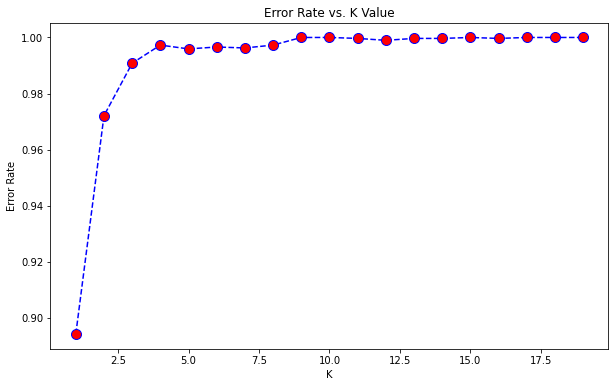

In [ ]:
error_rate = []
for i in range(1, 20):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train, y_train)
  prediction = knn.predict(X_test)
  error_rate.append(np.mean(prediction != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train,y_train)

pred_train_knn= knn.predict(X_train)
print('MSE of training dataset: %0.2f '  % mean_squared_error(y_train,pred_train_knn))
print('MAE of training dataset: %0.2f ' % mean_absolute_error(y_train,pred_train_knn))
print('R2 Score of training dataset: %0.2f ' % r2_score(y_train, pred_train_knn))

pred_test_knn= knn.predict(X_test)
print('MSE of test dataset: %0.2f' % mean_squared_error(y_test,pred_test_knn))
print('MAE of test dataset: %0.2f'  % mean_absolute_error(y_test,pred_test_knn))
print('R2 Score of test dataset: %0.2f' % r2_score(y_test, pred_test_knn))




MSE of training dataset: 71.91 
MAE of training dataset: 0.36 
R2 Score of training dataset: 1.00 
MSE of test dataset: 142289.88
MAE of test dataset: 187.33
R2 Score of test dataset: 0.58


#### PCA

In [ ]:
knn.fit(X_PCA_train,y_train)

pred_train_knn_PCA= knn.predict(X_PCA_train)
print('MSE of training dataset after PCA dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_knn_PCA))
print('MAE of training dataset  after PCA dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_knn_PCA))
print('R2 Score of training dataset  after PCA dim reduction: %0.2f ' % r2_score(y_train, pred_train_knn_PCA))

pred_test_knn_PCA= knn.predict(X_PCA_test)
print('MSE of test dataset  after PCA dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_knn_PCA))
print('MAE of test dataset  after PCA dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_knn_PCA))
print('R2 Score of test dataset  after PCA dim reduction: %0.2f' % r2_score(y_test, pred_test_knn_PCA))

MSE of training dataset after PCA dim reduction: 72.27 
MAE of training dataset  after PCA dim reduction: 0.37 
R2 Score of training dataset  after PCA dim reduction: 1.00 
MSE of test dataset  after PCA dim reduction: 171794.27
MAE of test dataset  after PCA dim reduction: 201.11
R2 Score of test dataset  after PCA dim reduction: 0.50


#### kernel PCA

In [ ]:
knn.fit(X_kernel_PCA_train,y_train)

pred_train_knn_kPCA= knn.predict(X_kernel_PCA_train)
print('MSE of training dataset after kernel PCA dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_knn_kPCA))
print('MAE of training dataset  after kernel PCA dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_knn_kPCA))
print('R2 Score of training dataset  after kernel PCA dim reduction: %0.2f ' % r2_score(y_train, pred_train_knn_kPCA))

pred_test_knn_kPCA= knn.predict(X_kernel_PCA_test)
print('MSE of test dataset  after kernel PCA dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_knn_kPCA))
print('MAE of test dataset  after kernel PCA dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_knn_kPCA))
print('R2 Score of test dataset  after kernel PCA dim reduction: %0.2f' % r2_score(y_test, pred_test_knn_kPCA))

MSE of training dataset after kernel PCA dim reduction: 0.00 
MAE of training dataset  after kernel PCA dim reduction: 0.00 
R2 Score of training dataset  after kernel PCA dim reduction: 1.00 
MSE of test dataset  after kernel PCA dim reduction: 157626.10
MAE of test dataset  after kernel PCA dim reduction: 195.58
R2 Score of test dataset  after kernel PCA dim reduction: 0.54


#### t-SNE

In [ ]:
knn.fit(X_tSNE_train,y_train)

pred_train_tsne= knn.predict(X_tSNE_train)
print('MSE of training dataset after tsne dim reduction: %0.2f '  % mean_squared_error(y_train,pred_train_tsne))
print('MAE of training dataset  after tsne  dim reduction: %0.2f ' % mean_absolute_error(y_train,pred_train_tsne))
print('R2 Score of training dataset  after tsne  dim reduction: %0.2f ' % r2_score(y_train, pred_train_tsne))

pred_test_tsne= knn.predict(X_tSNE_test)
print('MSE of test dataset  after tsne  dim reduction: %0.2f' % mean_squared_error(y_test,pred_test_tsne))
print('MAE of test dataset  after tsne  dim reduction: %0.2f'  % mean_absolute_error(y_test,pred_test_tsne))
print('R2 Score of test dataset  after tsne  dim reduction: %0.2f' % r2_score(y_test, pred_test_tsne))

MSE of training dataset after tsne dim reduction: 33.40 
MAE of training dataset  after tsne  dim reduction: 0.23 
R2 Score of training dataset  after tsne  dim reduction: 1.00 
MSE of test dataset  after tsne  dim reduction: 184003.10
MAE of test dataset  after tsne  dim reduction: 208.87
R2 Score of test dataset  after tsne  dim reduction: 0.46


## Ridge Regression

In [ ]:
#Ridge Regression
rr = Ridge(alpha=0.01)
rsCV = RandomizedSearchCV(rr,cv= 5,param_distributions={'alpha':np.linspace(0,20,100)})
rsCV.fit(train_data, y_train) 

pred_train_rr= rsCV.predict(train_data)
print('RMSE train', mean_squared_error(y_train,pred_train_rr))
print('MAE train', mean_absolute_error(y_train,pred_train_rr))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rsCV.predict(test_data)
print('RMSE test',mean_squared_error(y_test,pred_test_rr)) 
print('MAE test', mean_absolute_error(y_test,pred_test_rr))
print(r2_score(y_test, pred_test_rr))

RMSE train 98398.83970988664
MAE train 160.1229728733324
0.7202982629410468
RMSE test 100081.37118145802
MAE test 160.29458963375572
0.7066870485524814


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


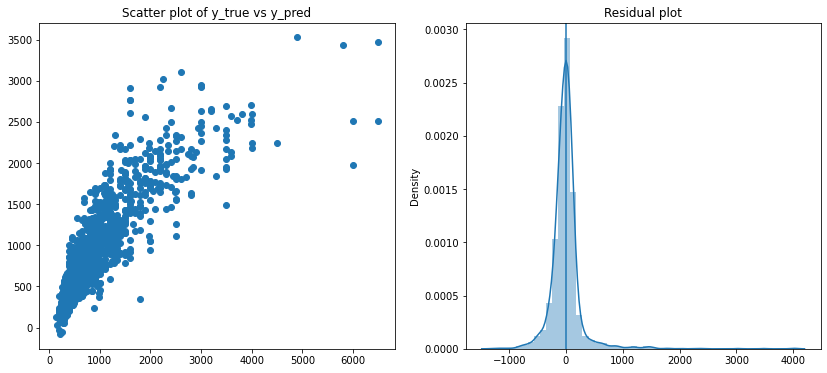

In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_rr)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_rr
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

## Linear Regression

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)

pred_train_lr= lr.predict(X_train)
print('MSE of training dataset: %0.2f '  % mean_squared_error(y_train,pred_train_lr))
print('MAE of training dataset: %0.2f ' % mean_absolute_error(y_train,pred_train_lr))
print('R2 Score of training dataset: %0.2f ' % r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test)
print('MSE of test dataset: %0.2f' % mean_squared_error(y_test,pred_test_lr))
print('MAE of test dataset: %0.2f'  % mean_absolute_error(y_test,pred_test_lr))
print('R2 Score of test dataset: %0.2f' % r2_score(y_test, pred_test_lr))

In [ ]:
print(lr.coef_)
print(lr.intercept_)

In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_lr)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_lr
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

## Lasso Regression

In [ ]:
#Lasso Regression
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 

pred_train_lasso= model_lasso.predict(X_train)
print(mean_squared_error(y_train,pred_train_lasso))
print(mean_absolute_error(y_train,pred_train_lasso))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(mean_squared_error(y_test,pred_test_lasso))
print(mean_absolute_error(y_test,pred_test_lasso))
print(r2_score(y_test, pred_test_lasso))

71626.44590082989
153.69023504346683
0.7963996181572014
75580.85937366646
155.17421937393166
0.7784917944855538


In [ ]:
f = plt.figure(figsize= (14,6))

ax = f.add_subplot(121)
ax.scatter(y_test, pred_test_lasso)
plt.title('Scatter plot of y_true vs y_pred')

residual = y_test - pred_test_lasso
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot');

## Decision Tree

In [ ]:
"""    Decision Tree      """

def DTR(rentalOffers, prices, headRentalOffers, criterion='mse',splitter='best', maxDepth=None,  maxFeatures=None):
    #normalization step
    rentalOffers=normalize(np.array(rentalOffers), norm='l2', axis=0)
     
    #used for the 10-fold cross-validation errors
    folds=1
    mse10=0
    mae10=0
    r2_10=0

    for i in range(folds):
      #split data into train and test
      rentalOffersTrain, rentalOffersTest, pricesTrain, pricesTest = train_test_split(rentalOffers, prices, test_size=0.30, shuffle=True)

      #create the model
      decisionTreeRegressor= DecisionTreeRegressor(criterion=criterion, splitter=splitter,max_depth=maxDepth, max_features=maxFeatures)
      #train the model
      decisionTreeRegressor.fit(rentalOffersTrain, pricesTrain)
      #predict the values for the test set
      predictedPrices=decisionTreeRegressor.predict(rentalOffersTest)
      
      ##plot the graph structure
      ##tree.plot_tree(decisionTreeRegressor,feature_names=headRentalOffers, fontsize=9)

      #calculate mse , mae and r2
      mse=mean_squared_error(pricesTest, predictedPrices)
      mae=mean_absolute_error(pricesTest, predictedPrices)
      r2=r2_score(pricesTest, predictedPrices)

      mse10+=mse
      mae10+=mae
      r2_10+=r2
      

    #calculate the average mse and mae
    mse10/=folds
    mae10/=folds
    r2_10/=folds

    print("Plot the last result")
    #plotValues(pricesTest, predictedPrices)
    fig=plt.figure(figsize=(14,6))
    ax=fig.add_subplot(121)
    ax.scatter(pricesTest, predictedPrices)
    plt.title("Scatter plot of y_true vs y_predicted")
    plt.show()
    residualPrices= pricesTest-predictedPrices
    #ax=fig.add_subplot(122)
    #sns.distplot(residualPrices,ax=ax)
    #plt.axvline(residualPrices.mean())
    #plt.title('Residual plot')

    #mostImportantFeature=headRentalOffers[np.argmax(decisionTreeRegressor.feature_importances_)]
    #mostUnimportantFeature=headRentalOffers[np.argmin(decisionTreeRegressor.feature_importances_)]
    #print("Important feature:  %s  Unimportant feature: %s"  %(mostImportantFeature, mostUnimportantFeature))
    #print("MSE=%d MAE=%d " %(mse,mae))

    return mse10, mae10, r2_10, residualPrices

"""   One hot encoding for numpy arrays   """
#create encoding for one column (column is a numpy array of shape (1,num_lines))
def one_hot_encoding(column):
  if len(np.array(column).shape)!=2:
    print("Column must have shape (1,num_lines) ")
    return

  length=int(column[0][np.argmax(column, axis=1)]+1)
  #print("length of encoding" , length)

  encoding=np.zeros((len(column[0]),length) )
  #print(encoding.shape)
  for (i, value) in enumerate(column[0]):
    #print(i, value)
    encoding[i][int(value)]=1

  return encoding

#add encoding instead of column
def add_one_hot_encoding(data, indexColumnFromData):
  columnFromData=np.array([data[:,indexColumnFromData]])
  encoding=one_hot_encoding(columnFromData)
  data=np.delete(np.array(data),indexColumnFromData, axis=1)
  data=np.concatenate((data, encoding), axis=1 )

  return data

def plotValues(y_true, y_predicted):
  plt.plot(y_true,y_predicted,'b.')
  plt.title("Scatter plot of y_true vs y_predicted")
  plt.show()
  return

""" Read data """
#read data from file
rentalOffers=pd.read_csv("house_rentals_features_1.csv")
headRentalOffers=rentalOffers.columns.values.tolist()
rentalOffers=rentalOffers.values

#read the prices
prices=pd.read_csv("house_rentals_clean.csv")
#convert to np.array
prices=prices['price'].values

print("Decision Tree Regressor")

In [ ]:
print("Applying Decision Tree Regressor on the data")

criteria=['mse']#, 'friedman_mse', 'mae']
splitters=['best']#,'random']
maxDepths=[ 10]#, 100, 2000]
maxFeaturesToUse=[5]#, 5, 10, 15]

for criterion in criteria:
  for splitter in splitters:
    for maxDepth in maxDepths:
      for maxFeatures in maxFeaturesToUse:
        mse,mae,r2, residualPrices=DTR(rentalOffers, prices, headRentalOffers, criterion, splitter, maxDepth,  maxFeatures)
        print("Criterion: %s; Splitter: %s; Maximum depth: %s; Maxiumum features: %s; MSE=%s; MAE=%s, R2=%s" %(criterion,splitter, str(maxDepth),  str(maxFeatures), str(mse), str(mae), str(r2)))
        
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(122)
sns.distplot(residualPrices,ax=ax)
plt.axvline(residualPrices.mean())
plt.title('Residual plot')

In [ ]:
""" One hot encoding """
# get indexes
indexLocationArea=headRentalOffers.index('location_area')
indexPartitioning=headRentalOffers.index('partitioning')-1  #the location_area column is in front of it and will be deleted
indexRealEstateType=headRentalOffers.index('real_estate_type')-2  #the location_area and partitioning columns are in front of it and will be deleted

#encoding the data
#print(rentalOffers.shape)
encodingRentalOffers=add_one_hot_encoding(np.array(rentalOffers), indexLocationArea)
#print(encodingRentalOffers.shape)
encodingRentalOffers=add_one_hot_encoding(np.array(encodingRentalOffers), indexPartitioning)
#print(encodingRentalOffers.shape)
encodingRentalOffers=add_one_hot_encoding(np.array(encodingRentalOffers), indexRealEstateType)
#print(encodingRentalOffers.shape)

print("Applying Decision Tree Regressor on the data after encoding the location_area, partitioning, real_estate_type columns")
print(encodingRentalOffers.shape)

criteria=['friedman_mse', 'mse', 'mae']
splitters=['random']#,'best']
maxDepths=[10] #None, 2, 100, 2000]
maxFeaturesToUse=[None]#, 10, 15]

for criterion in criteria:
  for splitter in splitters:
    for maxDepth in maxDepths:
      for maxFeatures in maxFeaturesToUse:
        print("-----------------------------------Decision Tree-----------------------------------------")
        mse,mae,r2, residualPrices=DTR(rentalOffers, prices, headRentalOffers, criterion, splitter, maxDepth,  maxFeatures)
        print("Criterion: %s; Splitter: %s; Maximum depth: %s; Maxiumum features: %s; MSE=%s; MAE=%s, R2=%s" %(criterion,splitter, str(maxDepth),  str(maxFeatures), str(mse), str(mae), str(r2)))
        #residual graph
        fig=plt.figure(figsize=(14,6))
        ax=fig.add_subplot(122)
        sns.distplot(residualPrices,ax=ax)
        plt.axvline(residualPrices.mean())
        plt.title('Residual plot')    